Clasificación de datos estructurados usando capas de preprocesamiento --- 0:00 min
===

* Última modificación: Marzo 7, 2022 | YouTube

Importación de librerías
---

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

tf.__version__

'2.8.0'

Dataset
---

```
Column          Pet description               Feature type   Data type 
--------------- ----------------------------- -------------- --------- 
`Type`          Type of animal (`Dog`, `Cat`) Categorical    String    
`Age`           Age                           Numerical      Integer   
`Breed1`        Primary breed                 Categorical    String    
`Color1`        Color 1                       Categorical    String    
`Color2`        Color 2                       Categorical    String    
`MaturitySize`  Size at maturity              Categorical    String    
`FurLength`     Fur length                    Categorical    String    
`Vaccinated`    Pet has been vaccinated       Categorical    String    
`Sterilized`    Pet has been sterilized       Categorical    String    
`Health`        Health condition              Categorical    String    
`Fee`           Adoption fee                  Numerical      Integer   
`Description`   Profile write-up              Text           String    
`PhotoAmt`      Total uploaded photos         Numerical      Integer   
`AdoptionSpeed` Categorical speed of adoption Classification Integer   
````


Descarga del dataset
---

In [2]:
dataset_url = (
    "http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip"
)
csv_file = "/tmp/petfinder-mini/petfinder-mini.csv"

tf.keras.utils.get_file(
    "petfinder_mini.zip",
    dataset_url,
    extract=True,
    cache_subdir="/tmp",
)

'/tmp/petfinder_mini.zip'

Carga usando pandas
--

In [3]:
import pandas as pd

dataframe = pd.read_csv(csv_file)

In [4]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


Creación de la variable objetivo
---

In [5]:
import numpy as np


#
# AdoptionSpeed == 4 indica que la mascota no fue adoptada
#
dataframe["target"] = np.where(dataframe["AdoptionSpeed"] == 4, 0, 1)

#
# Remoción de columnas innecesarias
#
dataframe = dataframe.drop(columns=["AdoptionSpeed", "Description"])

Partición del conjunto de datos
---

In [6]:
train, val, test = np.split(
    dataframe.sample(frac=1),
    [
        int(0.8 * len(dataframe)),
        int(0.9 * len(dataframe)),
    ],
)

In [7]:
print(len(train), "training examples")
print(len(val), "validation examples")
print(len(test), "test examples")

9229 training examples
1154 validation examples
1154 test examples


Creación de la tubería de datos con tf.data
---

In [8]:
def df_to_dataset(
    dataframe,
    shuffle=True,
    batch_size=32,
):
    # copia del dataframe para evitar efectos colaterles
    df = dataframe.copy()

    # extrae la variable objetivo
    labels = df.pop("target")

    # crea un diccionario {columna: contenido, ...}
    df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}

    # crea un slice de patrones
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))

    # mezcla los patrones
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))

    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)

    return ds

In [9]:
batch_size = 5

train_ds = df_to_dataset(
    train,
    batch_size=batch_size,
)

/tmp/ipykernel_5225/3038098572.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


In [10]:
#
# Take toma un batch
#
[(train_features, label_batch)] = train_ds.take(1)
print("Every feature:", list(train_features.keys()))
print("A batch of ages:", train_features["Age"])
print("A batch of targets:", label_batch)

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']
A batch of ages: tf.Tensor(
[[3]
 [2]
 [1]
 [8]
 [4]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)


Aplicación de capas de preprocesamiento
---

**Columnas numéricas**

In [11]:
def get_normalization_layer(name, dataset):
    normalizer = tf.keras.layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)
    return normalizer

In [12]:
photo_count_col = train_features["PhotoAmt"]
layer = get_normalization_layer("PhotoAmt", train_ds)
layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.82360405],
       [-0.19089566],
       [-0.50724983],
       [-0.50724983],
       [-0.19089566]], dtype=float32)>

**Columnas categóricas**

In [13]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):

    if dtype == "string":
        index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
    else:
        index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)

    feature_ds = dataset.map(lambda x, y: x[name])

    index.adapt(feature_ds)

    encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    return lambda feature: encoder(index(feature))

In [14]:
test_type_col = train_features["Type"]

test_type_layer = get_category_encoding_layer(
    name="Type",
    dataset=train_ds,
    dtype="string",
)

test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

In [15]:
test_age_col = train_features["Age"]

test_age_layer = get_category_encoding_layer(
    name="Age",
    dataset=train_ds,
    dtype="int64",
    max_tokens=5,
)

test_age_layer(test_age_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

Preprocesamiento de las características para entrenar el modelo
--

### Numerical columns

For each numeric feature in the PetFinder.my mini dataset, you will use a `tf.keras.layers.Normalization` layer to standardize the distribution of the data.

Define a new utility function that returns a layer which applies feature-wise normalization to numerical features using that Keras preprocessing layer:

In [16]:
batch_size = 256

train_ds = df_to_dataset(
    train,
    batch_size=batch_size,
)

val_ds = df_to_dataset(
    val,
    shuffle=False,
    batch_size=batch_size,
)

test_ds = df_to_dataset(
    test,
    shuffle=False,
    batch_size=batch_size,
)

/tmp/ipykernel_5225/3038098572.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_5225/3038098572.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_5225/3038098572.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


In [17]:
#
# Características numméricas
#
all_inputs = []
encoded_features = []

for header in ["PhotoAmt", "Fee"]:

    numeric_col = tf.keras.Input(
        shape=(1,),
        name=header,
    )

    normalization_layer = get_normalization_layer(
        header,
        train_ds,
    )

    encoded_numeric_col = normalization_layer(numeric_col)

    all_inputs.append(numeric_col)

    encoded_features.append(encoded_numeric_col)

In [18]:
#
# Variables categóricas numéricas
#
age_col = tf.keras.Input(
    shape=(1,),
    name="Age",
    dtype="int64",
)

encoding_layer = get_category_encoding_layer(
    name="Age",
    dataset=train_ds,
    dtype="int64",
    max_tokens=5,
)

encoded_age_col = encoding_layer(age_col)

all_inputs.append(age_col)

encoded_features.append(encoded_age_col)

In [19]:
#
# Variables categoricas de texto
#
categorical_cols = [
    "Type",
    "Color1",
    "Color2",
    "Gender",
    "MaturitySize",
    "FurLength",
    "Vaccinated",
    "Sterilized",
    "Health",
    "Breed1",
]

for header in categorical_cols:

    categorical_col = tf.keras.Input(
        shape=(1,),
        name=header,
        dtype="string",
    )

    encoding_layer = get_category_encoding_layer(
        name=header,
        dataset=train_ds,
        dtype="string",
        max_tokens=5,
    )
    encoded_categorical_col = encoding_layer(categorical_col)

    all_inputs.append(categorical_col)

    encoded_features.append(encoded_categorical_col)

Creación, compilación y entrenamiento del modelo
---

In [20]:
all_features = tf.keras.layers.concatenate(encoded_features)

x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(
    all_inputs,
    output,
)

In [21]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(
        from_logits=True,
    ),
    metrics=["accuracy"],
)

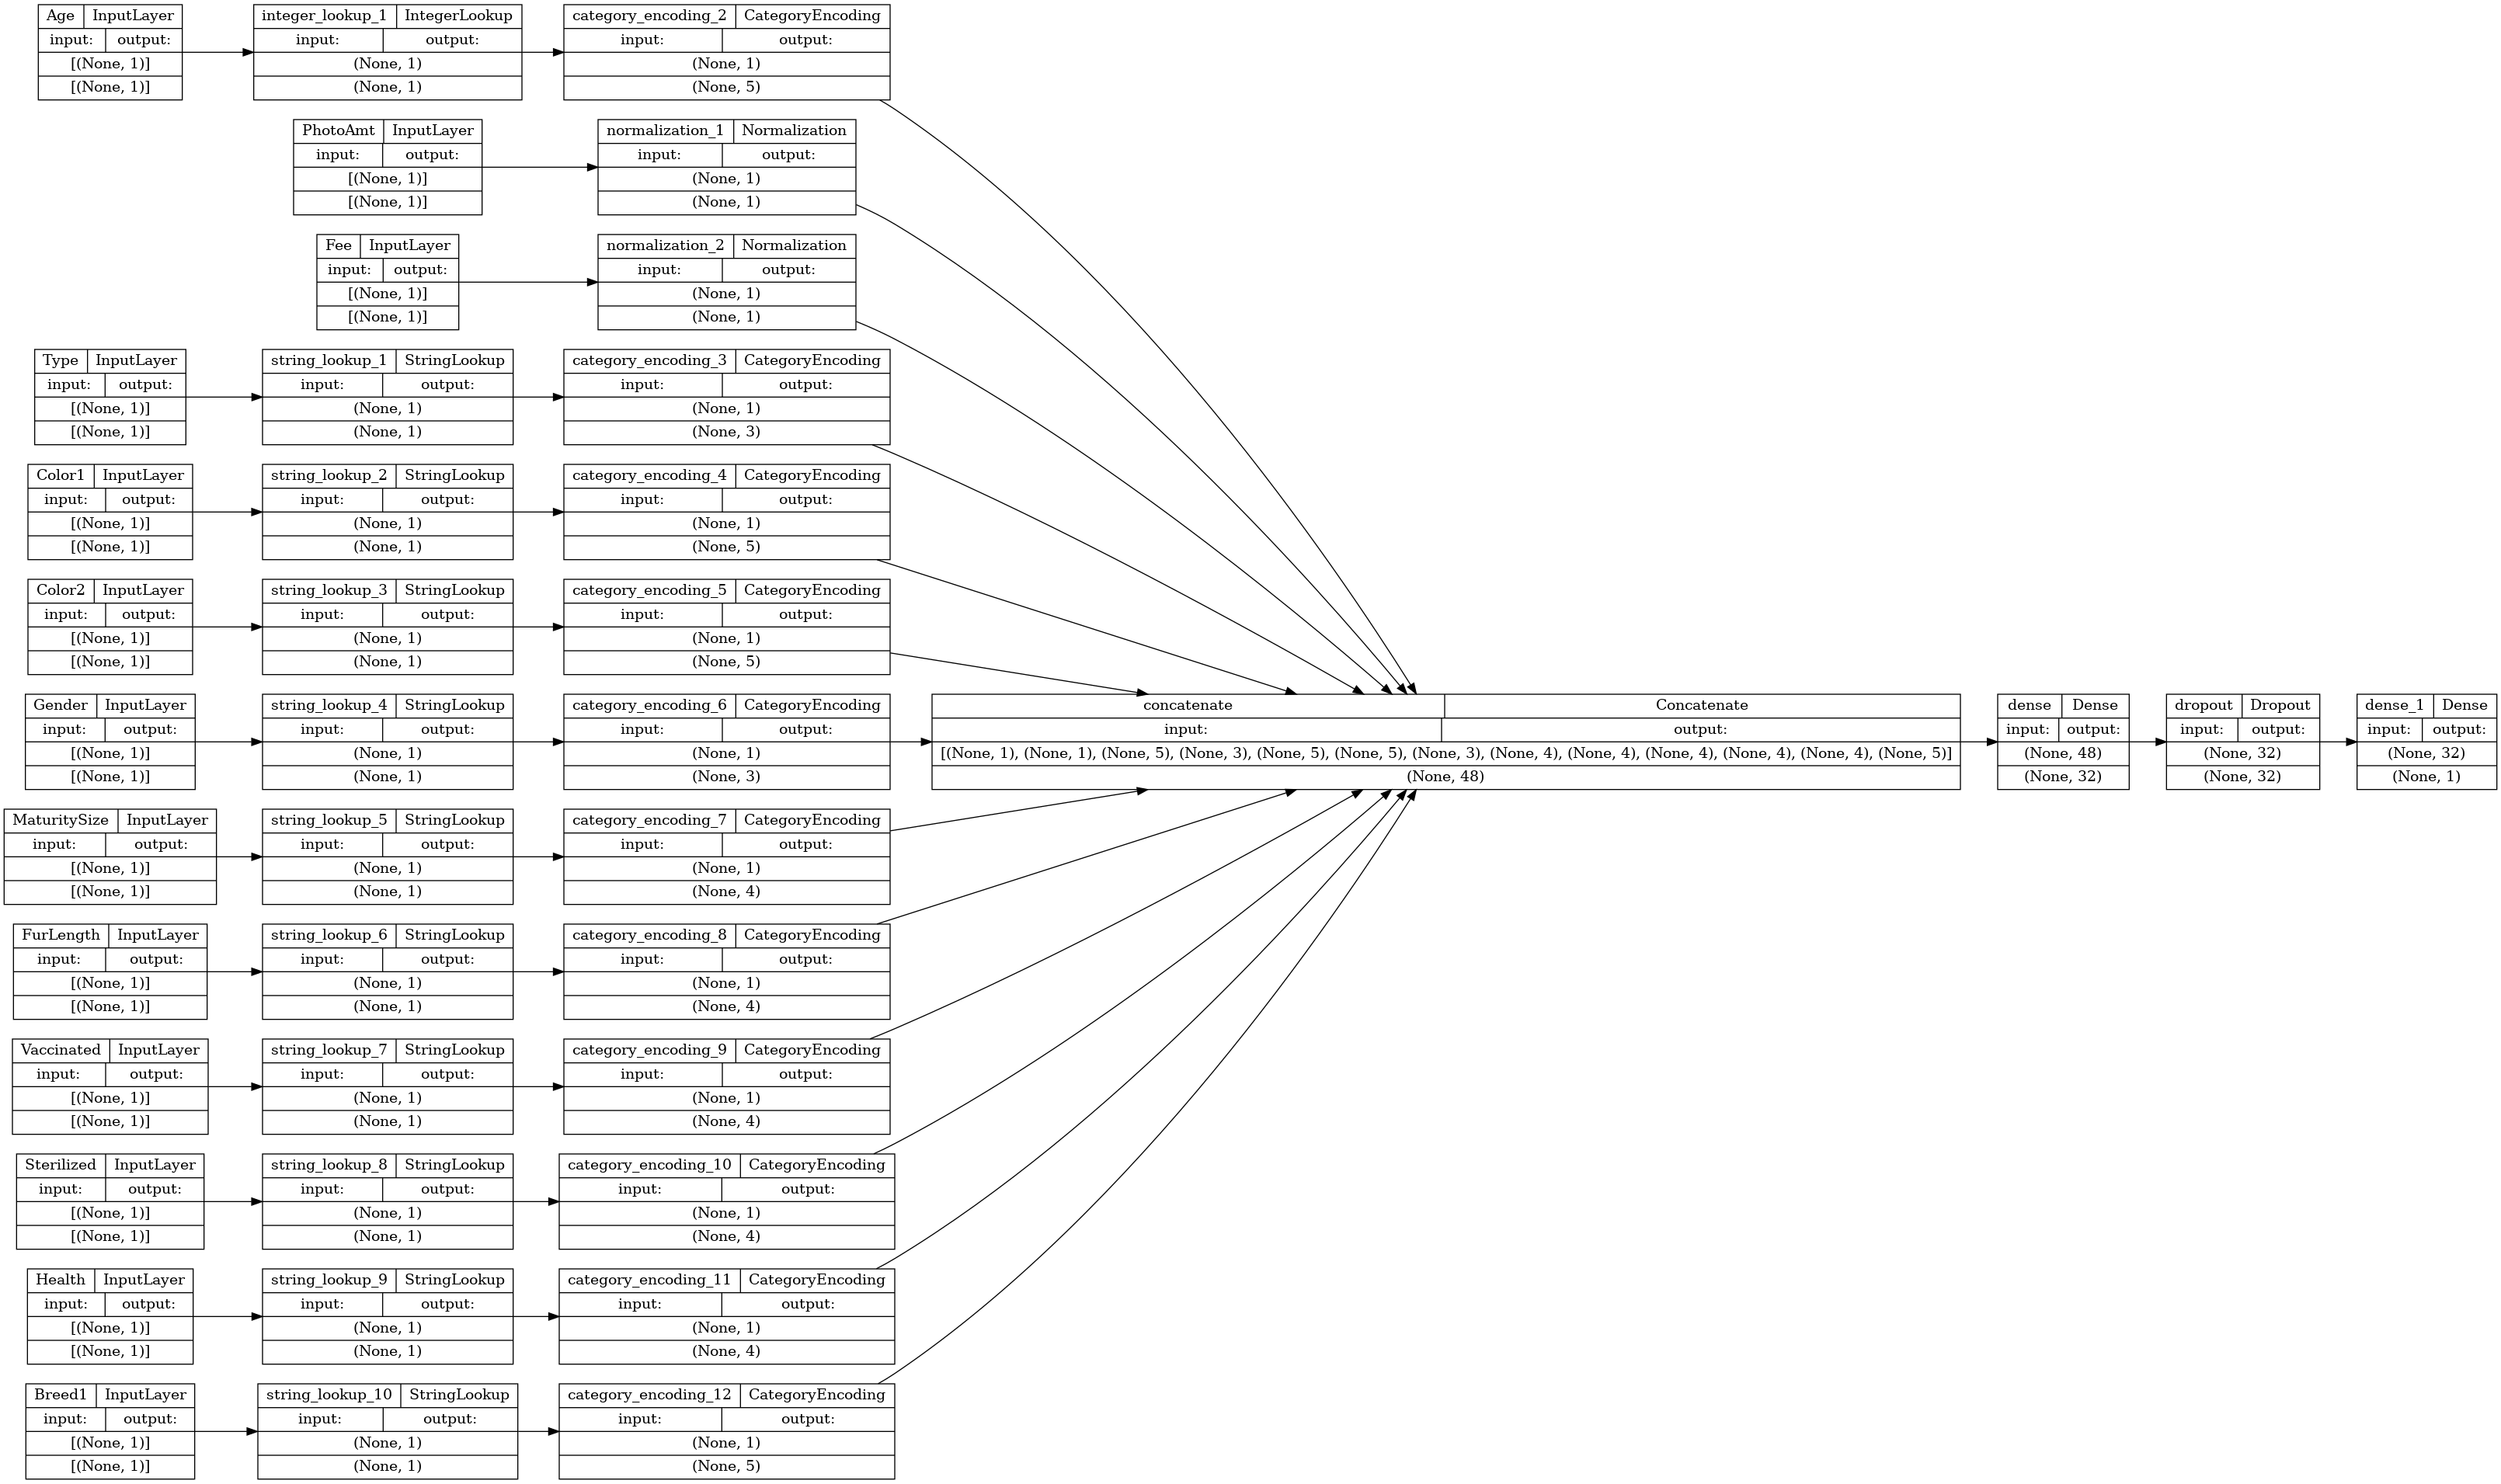

In [22]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    rankdir="LR",
)

In [23]:
model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

Epoch 1/10


/usr/local/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


37/37 [==============================] - 2s 16ms/step - loss: 0.6224 - accuracy: 0.6042 - val_loss: 0.5791 - val_accuracy: 0.7106
Epoch 2/10
37/37 [==============================] - 0s 7ms/step - loss: 0.5763 - accuracy: 0.6734 - val_loss: 0.5585 - val_accuracy: 0.7210
Epoch 3/10
37/37 [==============================] - 0s 7ms/step - loss: 0.5569 - accuracy: 0.6963 - val_loss: 0.5451 - val_accuracy: 0.7296
Epoch 4/10
37/37 [==============================] - 0s 7ms/step - loss: 0.5462 - accuracy: 0.7044 - val_loss: 0.5365 - val_accuracy: 0.7331
Epoch 5/10
37/37 [==============================] - 0s 7ms/step - loss: 0.5412 - accuracy: 0.7090 - val_loss: 0.5293 - val_accuracy: 0.7331
Epoch 6/10
37/37 [==============================] - 0s 7ms/step - loss: 0.5361 - accuracy: 0.7076 - val_loss: 0.5258 - val_accuracy: 0.7383
Epoch 7/10
37/37 [==============================] - 0s 7ms/step - loss: 0.5360 - accuracy: 0.7155 - val_loss: 0.5225 - val_accuracy: 0.7392
Epoch 8/10
37/37 [============

In [24]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

5/5 [==============================] - 0s 5ms/step - loss: 0.5305 - accuracy: 0.7452
Accuracy 0.745233952999115


Pronóstico
---

In [25]:
model.save("/tmp/my_pet_classifier")
reloaded_model = tf.keras.models.load_model("/tmp/my_pet_classifier")

INFO:tensorflow:Assets written to: /tmp/my_pet_classifier/assets


INFO:tensorflow:Assets written to: /tmp/my_pet_classifier/assets


In [26]:
sample = {
    "Type": "Cat",
    "Age": 3,
    "Breed1": "Tabby",
    "Gender": "Male",
    "Color1": "Black",
    "Color2": "White",
    "MaturitySize": "Small",
    "FurLength": "Short",
    "Vaccinated": "No",
    "Sterilized": "No",
    "Health": "Healthy",
    "Fee": 100,
    "PhotoAmt": 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

This particular pet had a 75.6 percent probability of getting adopted.
